In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

num_cores = 8
torch.set_num_interop_threads(num_cores) # Inter-op parallelism
torch.set_num_threads(num_cores) # Intra-op parallelism

In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
def c3_to_c1(y):
    if y < 2 or y > 7:
        return 0
    return 1

def c3_to_c2(y):
    match y:
        case 0:
            return 0
        case 1:
            return 2
        case 2:
            return 3
        case 3:
            return 5
        case 4:
            return 6
        case 5:
            return 5
        case 6:
            return 4
        case 7:
            return 6
        case 8:
            return 1
        case _:
            return 2

def c2_to_c1(y):
    if y < 3:
        return 0
    return 1

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

coarser = Lambda(lambda y: torch.tensor([c3_to_c1(y), c3_to_c2(y), int(y)]))

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform, target_transform = coarser)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_cores)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform, target_transform = coarser)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_cores)

In [5]:
def debug_hierarchy_labels():
    for i in np.arange(10):
        print(f'{labels_c_3[i]} -> ({labels_c_2[c3_to_c2(i)]}, {labels_c_1[c3_to_c1(i)]})')
    
    print("")
    for i in np.arange(7):
        print(f'{labels_c_2[i]} -> ({labels_c_1[c2_to_c1(i)]})')

In [6]:
class BCNN3(nn.Module):
    def __init__(self, alpha, beta, gamma, learning_rate, momentum, nesterov, trainloader, testloader, 
                 epochs, num_class_c1, num_class_c2, num_class_c3, labels_c_1, labels_c_2, labels_c_3, 
                 every_print = 512, training_size = 50000):
        
        super().__init__()
        self.trainloader = trainloader
        self.testloader = testloader
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.nesterov = nesterov
        self.alphas = alpha
        self.betas = beta
        self.gammas = gamma
        self.alpha = self.alphas[0]
        self.beta = self.betas[0]
        self.gamma = self.gammas[0]
        self.activation = F.relu
        self.class_levels = 3
        self.num_c_1 = num_class_c1
        self.num_c_2 = num_class_c2
        self.num_c_3 = num_class_c3
        self.epochs = epochs
        self.epoch_error = 0.
        self.labels_c_1 = labels_c_1
        self.labels_c_2 = labels_c_2
        self.labels_c_3 = labels_c_3
        self.every_print = every_print - 2 # assumed power of 2, -1 to make the mask, -1 not to do iter +1
        self.track_size = int( training_size / batch_size / every_print )

        self.layer1  = nn.Conv2d(3, 64, (3,3), padding = 'same')
        self.layer2  = nn.BatchNorm2d(64)
        self.layer3  = nn.Conv2d(64, 64, (3,3), padding = 'same')
        self.layer4  = nn.BatchNorm2d(64)
        self.layer5  = nn.MaxPool2d((2,2), stride = (2,2))

        self.layer6  = nn.Conv2d(64, 128, (3,3), padding = 'same')
        self.layer7  = nn.BatchNorm2d(128)
        self.layer8  = nn.Conv2d(128, 128, (3,3), padding = 'same')
        self.layer9  = nn.BatchNorm2d(128)
        self.layer10 = nn.MaxPool2d((2,2), stride = (2,2))

        self.layerb11 = nn.Linear(8*8*128, 256)
        self.layerb12 = nn.BatchNorm1d(256)
        self.layerb13 = nn.Dropout(0.5)
        self.layerb14 = nn.Linear(256, 256)
        self.layerb15 = nn.BatchNorm1d(256)
        self.layerb16 = nn.Dropout(0.5)
        self.layerb17 = nn.Linear(256, self.num_c_1)

        self.layer11 = nn.Conv2d(128, 256, (3,3), padding = 'same')
        self.layer12 = nn.BatchNorm2d(256)
        self.layer13 = nn.Conv2d(256, 256, (3,3), padding = 'same')
        self.layer14 = nn.BatchNorm2d(256)
        self.layer15 = nn.MaxPool2d((2,2), stride = (2,2))

        self.layerb21 = nn.Linear(4*4*256, 512)
        self.layerb22 = nn.BatchNorm1d(512)
        self.layerb23 = nn.Dropout(0.5)
        self.layerb24 = nn.Linear(512, 512)
        self.layerb25 = nn.BatchNorm1d(512)
        self.layerb26 = nn.Dropout(0.5)
        self.layerb27 = nn.Linear(512, self.num_c_2)

        self.layer16 = nn.Conv2d(256, 512, (3,3), padding = 'same')
        self.layer17 = nn.BatchNorm2d(512)
        self.layer18 = nn.Conv2d(512, 512, (3,3), padding = 'same')
        self.layer19 = nn.BatchNorm2d(512)
        self.layer20 = nn.MaxPool2d((2,2), stride = (2,2))

        self.layerb31 = nn.Linear(2*2*512, 1024)
        self.layerb32 = nn.BatchNorm1d(1024)
        self.layerb33 = nn.Dropout(0.5)
        self.layerb34 = nn.Linear(1024, 1024)
        self.layerb35 = nn.BatchNorm1d(1024)
        self.layerb36 = nn.Dropout(0.5)
        self.layerb37 = nn.Linear(1024, self.num_c_3)

        self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate[0], 
                                   momentum = self.momentum, nesterov = self.nesterov)
        self.criterion = nn.CrossEntropyLoss()


    def forward(self, x):

        # block 1
        z = self.layer1(x)
        z = self.activation(z)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.activation(z)
        z = self.layer4(z)
        z = self.layer5(z)

        # block 2
        z = self.layer6(z)
        z = self.activation(z)
        z = self.layer7(z)
        z = self.layer8(z)
        z = self.activation(z)
        z = self.layer9(z)
        z = self.layer10(z)

        # branch 1
        b1 = torch.flatten(z, start_dim = 1)
        b1 = self.layerb11(b1)
        b1 = self.activation(b1)
        b1 = self.layerb12(b1)
        b1 = self.layerb13(b1)
        b1 = self.layerb14(b1)
        b1 = self.activation(b1)
        b1 = self.layerb15(b1)
        b1 = self.layerb16(b1)
        b1 = self.layerb17(b1)

        # block 3
        z = self.layer11(z)
        z = self.activation(z)
        z = self.layer12(z)
        z = self.layer13(z)
        z = self.activation(z)
        z = self.layer14(z)
        z = self.layer15(z)
        
        # branch 2
        b2 = torch.flatten(z, start_dim = 1)
        b2 = self.layerb21(b2)
        b2 = self.activation(b2)
        b2 = self.layerb22(b2)
        b2 = self.layerb23(b2)
        b2 = self.layerb24(b2)
        b2 = self.activation(b2)
        b2 = self.layerb25(b2)
        b2 = self.layerb26(b2)
        b2 = self.layerb27(b2)

        # block 4
        z = self.layer16(z)
        z = self.activation(z)
        z = self.layer17(z)
        z = self.layer18(z)
        z = self.activation(z)
        z = self.layer19(z)
        z = self.layer20(z)

        # branch 3
        b3 = torch.flatten(z, start_dim = 1)
        b3 = self.layerb31(b3)
        b3 = self.activation(b3)
        b3 = self.layerb32(b3)
        b3 = self.layerb33(b3)
        b3 = self.layerb34(b3)
        b3 = self.activation(b3)
        b3 = self.layerb35(b3)
        b3 = self.layerb36(b3)
        b3 = self.layerb37(b3)
        
        
        return b1, b2, b3


    def update_training_params(self, epoch):
        if epoch == 9:
            self.alpha = self.alphas[1]
            self.beta = self.betas[1]
            self.gamma = self.gammas[1]
        elif epoch == 19:
            self.alpha = self.alphas[2]
            self.beta = self.betas[2]
            self.gamma = self.gammas[2]
        elif epoch == 29:
            self.alpha = self.alphas[3]
            self.beta = self.betas[3]
            self.gamma = self.gammas[3]
        elif epoch == 41:
            self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate[1], 
                               momentum = self.momentum, nesterov = self.nesterov)
        elif epoch == 51:
            self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate[2], 
                               momentum = self.momentum, nesterov = self.nesterov)


    def predict_and_learn(self, batch, labels):
        self.optimizer.zero_grad()
        predict = self(batch)
        loss =  self.alpha * self.criterion(predict[0], labels[:,0]) + \
                self.beta * self.criterion(predict[1], labels[:,1]) + \
                self.gamma * self.criterion(predict[2], labels[:,2])

        loss.backward()
        self.optimizer.step()

        return loss

    
    def train(self, verbose = False):

        for epoch in np.arange(self.epochs):
            print(epoch)
            self.update_training_params(epoch)

            if verbose:
                running_loss = 0.
            
            for iter, (batch, labels) in enumerate(self.trainloader):
                loss = self.predict_and_learn(batch, labels)

                if verbose:
                    running_loss += (loss.item() - running_loss) / (iter+1)
                    if iter & self.every_print == 0:
                        print(f'[{epoch + 1}] loss: {running_loss :.3f}')
                        running_loss = 0.0

    
    def train_track(self):
        self.loss_track = torch.zeros(self.epochs * self.track_size)
        self.accuracy_track = torch.zeros(self.epochs * self.track_size, self.class_levels)
        num_push = 0
        
        for epoch in np.arange(self.epochs):

            self.update_training_params(epoch)

            running_loss = 0.
            
            for iter, (batch, labels) in enumerate(self.trainloader):
                loss = self.predict_and_learn(batch, labels)

                running_loss += (loss.item() - running_loss) / (iter+1)
                if iter & self.every_print == 0:
                    self.loss_track[epoch * num_push] = running_loss
                    self.accuracy_track[epoch * num_push, :] = self.test(mode = "train")
                    num_push += 1
                    running_loss = 0.0

        self.plot_training_loss()
        self.plot_test_loss()


    def initialize_memory(self):
        self.correct_c1_pred = torch.zeros(self.num_c_1)
        self.total_c1_pred = torch.zeros_like(self.correct_c1_pred)
        
        self.correct_c2_pred = torch.zeros(self.num_c_2)
        self.total_c2_pred = torch.zeros_like(self.correct_c2_pred)
        
        self.correct_c3_pred = torch.zeros(self.num_c_3)
        self.total_c3_pred = torch.zeros_like(self.correct_c3_pred)

        self.correct_c1_vs_c2_pred = torch.zeros(self.num_c_1)
        self.total_c1_vs_c2_pred = torch.zeros_like(self.correct_c1_vs_c2_pred)

        self.correct_c2_vs_c3_pred = torch.zeros(self.num_c_2)
        self.total_c2_vs_c3_pred = torch.zeros_like(self.correct_c2_vs_c3_pred)

        self.correct_c1_vs_c3_pred = torch.zeros(self.num_c_1)
        self.total_c1_vs_c3_pred = torch.zeros_like(self.correct_c1_vs_c3_pred)

    
    def collect_test_performance(self):
        with torch.no_grad():
            for images, labels in self.testloader:
                predicitions = self(images)
                predicted = torch.zeros(predicitions[0].size(0), self.class_levels, dtype=torch.long)
                _, predicted[:,0] = torch.max(predicitions[0], 1)
                _, predicted[:,1] = torch.max(predicitions[1], 1)
                _, predicted[:,2] = torch.max(predicitions[2], 1)

                for i in np.arange(predicitions[0].size(0)):
                    if labels[i,0] == predicted[i,0]:
                        self.correct_c1_pred[labels[i,0]] += 1
                        
                    if labels[i,1] == predicted[i,1]:
                        self.correct_c2_pred[labels[i,1]] += 1

                    if labels[i,2] == predicted[i,2]:
                        self.correct_c3_pred[labels[i,2]] += 1

                    if predicted[i,1] == c3_to_c2(predicted[i,2]):
                        self.correct_c2_vs_c3_pred[predicted[i,1]] += 1

                    if predicted[i,0] == c3_to_c1(predicted[i,2]):
                        self.correct_c1_vs_c3_pred[predicted[i,0]] += 1

                    if predicted[i,0] == c2_to_c1(predicted[i,1]):
                        self.correct_c1_vs_c2_pred[predicted[i,0]] += 1
                        
                    self.total_c1_pred[labels[i,0]] += 1
                    self.total_c2_pred[labels[i,1]] += 1
                    self.total_c3_pred[labels[i,2]] += 1
                    self.total_c1_vs_c3_pred[predicted[i,0]] += 1
                    self.total_c1_vs_c2_pred[predicted[i,0]] += 1
                    self.total_c2_vs_c3_pred[predicted[i,1]] += 1
                    

    def print_test_results(self):
        # print accuracy for each class
        for i in np.arange(self.num_c_1):
            accuracy_c1 = 100 * float(self.correct_c1_pred[i]) / self.total_c1_pred[i]
            print(f'Accuracy for class {self.labels_c_1[i]:5s}: {accuracy_c1:.2f} %')

        print("")
        for i in np.arange(self.num_c_2):
            accuracy_c2 = 100 * float(self.correct_c2_pred[i]) / self.total_c2_pred[i]
            print(f'Accuracy for class {self.labels_c_2[i]:5s}: {accuracy_c2:.2f} %')

        print("")
        for i in np.arange(self.num_c_3):
            accuracy_c3 = 100 * float(self.correct_c3_pred[i]) / self.total_c3_pred[i]
            print(f'Accuracy for class {self.labels_c_3[i]:5s}: {accuracy_c3:.2f} %')
            
        # print accuracy for the whole dataset
        print("")
        print(f'Accuracy on c1: {100 * self.correct_c1_pred.sum() // self.total_c1_pred.sum()} %')
        print(f'Accuracy on c2: {100 * self.correct_c2_pred.sum() // self.total_c2_pred.sum()} %')
        print(f'Accuracy on c3: {100 * self.correct_c3_pred.sum() // self.total_c3_pred.sum()} %')

        # print cross classes accuracy (tree)
        print("")
        for i in np.arange(self.num_c_1):
            accuracy_c1_c2 = 100 * float(self.correct_c1_vs_c2_pred[i]) / self.total_c1_vs_c2_pred[i]
            print(f'Cross-accuracy {self.labels_c_1[i]:5s} vs c2: {accuracy_c1_c2:.2f} %')
        
        print("")
        for i in np.arange(self.num_c_2):
            accuracy_c2_c3 = 100 * float(self.correct_c2_vs_c3_pred[i]) / self.total_c2_vs_c3_pred[i]
            print(f'Cross-accuracy {self.labels_c_2[i]:5s} vs c3: {accuracy_c2_c3:.2f} %')

        print("")
        for i in np.arange(self.num_c_1):
            accuracy_c1_c3 = 100 * float(self.correct_c1_vs_c3_pred[i]) / self.total_c1_vs_c3_pred[i]
            print(f'Cross-accuracy {self.labels_c_1[i]:5s} vs c3: {accuracy_c1_c3:.2f} %')


    def barplot(self, x, accuracy, labels, title):
        plt.bar(x, accuracy, tick_label = labels)
        plt.xlabel("Classes")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.show();

    def plot_test_results(self):
        # accuracy for each class
        accuracy_c1 = torch.empty(self.num_c_1)
        for i in np.arange(self.num_c_1):
            accuracy_c1[i] = float(self.correct_c1_pred[i]) / self.total_c1_pred[i]
        self.barplot(np.arange(self.num_c_1), accuracy_c1, self.labels_c_1, "Accuracy on the first level")

        accuracy_c2 = torch.empty(self.num_c_2 + 1)
        for i in np.arange(self.num_c_2):
            accuracy_c2[i] = float(self.correct_c2_pred[i]) / self.total_c2_pred[i]
        accuracy_c2[self.num_c_2] = self.correct_c2_pred.sum() / self.total_c2_pred.sum()
        self.barplot(np.arange(self.num_c_2 + 1), accuracy_c2, (*self.labels_c_2, 'overall'), "Accuracy on the second level")

        accuracy_c3 = torch.empty(self.num_c_3 + 1)
        for i in np.arange(self.num_c_3):
            accuracy_c3[i] = float(self.correct_c3_pred[i]) / self.total_c3_pred[i]
        accuracy_c3[self.num_c_3] = self.correct_c3_pred.sum() / self.total_c3_pred.sum()
        self.barplot(np.arange(self.num_c_3 + 1), accuracy_c3, (*self.labels_c_3, 'overall'), "Accuracy on the third level")

    
    def test(self, mode = "print"):
        self.initialize_memory()

        self.collect_test_performance()

        match mode:
            case "plot":
                self.plot_test_results()
            case "print":
                self.print_test_results()
            case "train":
                accuracy_c1 = self.correct_c1_pred.sum() / self.total_c1_pred.sum()
                accuracy_c2 = self.correct_c2_pred.sum() / self.total_c2_pred.sum()
                accuracy_c3 = self.correct_c3_pred.sum() / self.total_c3_pred.sum()

                return accuracy_c1, accuracy_c2, accuracy_c3
            case _:
                raise AttributeError("Test mode not available")
        
    
    def plot_training_loss(self):
        plt.figure(figsize=(12, 6))
        plt.plot(np.linspace(1, self.epochs, self.loss_track.size(0)), self.loss_track.numpy())
        plt.title("Training loss")
        plt.xlabel("Epochs")
        plt.ylabel("Error")
        plt.xticks(np.linspace(1, self.epochs, self.epochs)[0::2])
        plt.show();

    def plot_test_accuracy(self):
        plt.figure(figsize=(12, 6))
        plt.plot(np.linspace(1, self.epochs, self.loss_track.size(0)), self.accuracy_track[:, 0].numpy(), label = "First level")
        plt.plot(np.linspace(1, self.epochs, self.loss_track.size(0)), self.accuracy_track[:, 1].numpy(), label = "Second level")
        plt.plot(np.linspace(1, self.epochs, self.loss_track.size(0)), self.accuracy_track[:, 2].numpy(), label = "Third level")
        plt.title("Test accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.xticks(np.linspace(1, self.epochs, self.epochs)[0::2])
        plt.legend()
        plt.show();


In [7]:
alpha = [0.98, 0.1, 0.1, 0.]
beta = [0.01, 0.8, 0.2, 0.]
gamma = [0.01, 0.1, 0.1, 1.]
learning_rate = [3e-3, 5e-4, 1e-4]
momentum = 0.9
nesterov = True
epochs = 60
num_class_c1 = 2
num_class_c2 = 7
num_class_c3 = 10

#--- coarse 1 classes ---
labels_c_1 = ('transport', 'animal')
#--- coarse 2 classes ---
labels_c_2 = ('sky', 'water', 'road', 'bird', 'reptile', 'pet', 'medium')
#--- fine classes ---
labels_c_3 = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
cnn = BCNN3(alpha, beta, gamma, learning_rate, momentum, nesterov, trainloader, testloader, 
                 epochs, num_class_c1, num_class_c2, num_class_c3, labels_c_1, labels_c_2, labels_c_3)

In [9]:
#cnn.train(verbose = True)
#cnn.train_track()

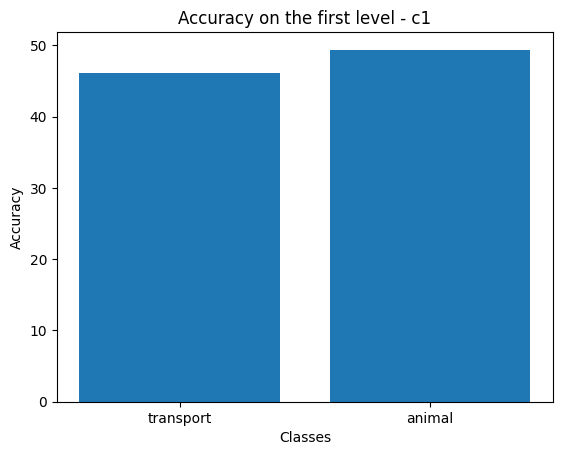

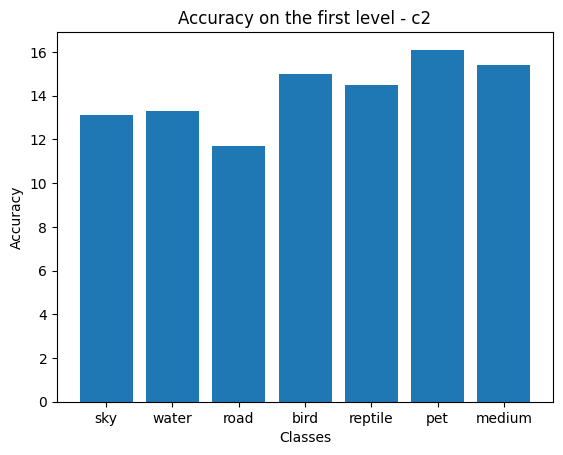

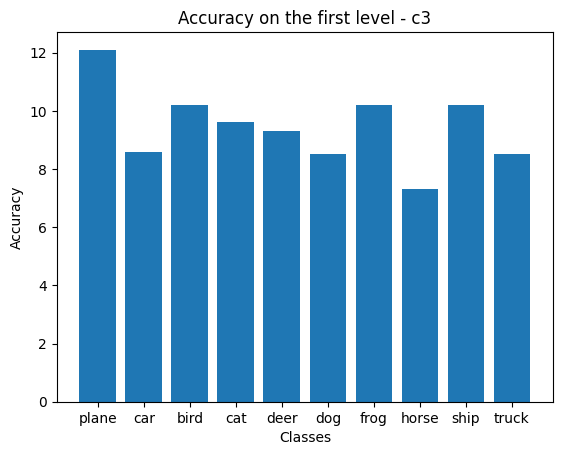

In [10]:
cnn.test(mode = "plot")